We are dealing again with the dataset related to movies. You probably already have downloaded the data movies.csv from Madoc. We want to predict popularity. Let's start with computing some basic statistics on it, as we need to know what type of attribute popularity is, and also have the general characteristics of the data.


In [191]:
# coding: utf8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals.six import StringIO 
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics  import mean_absolute_error, median_absolute_error, r2_score, mean_squared_error
from math import sqrt
from scipy import stats 
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [176]:
data = pd.read_csv('movies.csv')
data.head()

,title,year,budget,revenue,runtime,vote_count,vote_average,popularity,wr,Action,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Inception,2010,160000000,8.255328e+08,148.0,14075,8,29.108149,7.917588,True,...,False,False,False,True,False,True,False,True,False,False
1,The Dark Knight,2008,185000000,1.004558e+09,152.0,12269,8,123.167259,7.905871,True,...,False,False,False,False,False,False,False,True,False,False
2,Interstellar,2014,165000000,6.751200e+08,169.0,11187,8,32.213481,7.897107,False,...,False,False,False,False,False,True,False,False,False,False
3,Fight Club,1999,63000000,1.008538e+08,139.0,9678,8,63.869599,7.881753,False,...,False,False,False,False,False,False,False,False,False,False
4,The Lord of the Rings: The Fellowship of the Ring,2001,93000000,8.713684e+08,178.0,8892,8,32.070725,7.871787,True,...,False,False,False,False,False,False,False,False,False,False


In [177]:
#no missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2274 entries, 0 to 2273
Data columns (total 28 columns):
title              2274 non-null object
year               2274 non-null int64
budget             2274 non-null int64
revenue            2274 non-null float64
runtime            2274 non-null float64
vote_count         2274 non-null int64
vote_average       2274 non-null int64
popularity         2274 non-null float64
wr                 2274 non-null float64
Action             2274 non-null bool
Adventure          2274 non-null bool
Animation          2274 non-null bool
Comedy             2274 non-null bool
Crime              2274 non-null bool
Documentary        2274 non-null bool
Drama              2274 non-null bool
Family             2274 non-null bool
Fantasy            2274 non-null bool
History            2274 non-null bool
Horror             2274 non-null bool
Music              2274 non-null bool
Mystery            2274 non-null bool
Romance            2274 non-null bool
S

In [178]:
# basic statistics
data.describe()

,year,budget,revenue,runtime,vote_count,vote_average,popularity,wr
count,2274.000000,2.274000e+03,2.274000e+03,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000
mean,2003.956464,5.008957e+07,1.773572e+08,112.205365,1582.002199,6.159631,14.442752,5.917937
std,12.889061,5.198794e+07,2.242483e+08,24.329324,1570.502308,0.839273,19.780997,0.643664
min,1927.000000,0.000000e+00,0.000000e+00,6.000000,434.000000,2.000000,0.010902,3.549269
25%,2000.000000,1.207500e+07,4.012576e+07,97.000000,628.000000,6.000000,8.987296,5.647997
50%,2008.000000,3.300000e+07,1.048920e+08,109.000000,984.000000,6.000000,11.442298,5.818692
75%,2013.000000,7.000000e+07,2.243865e+08,123.000000,1831.000000,7.000000,14.777679,6.399752
max,2017.000000,3.800000e+08,2.787965e+09,705.000000,14075.000000,9.000000,547.488298,7.917588


Attribute 'Popularity' is numeric. We could still make this into a classification task (how?) but decide to go for regression instead. Does this make sense? In the lectures we were told about linear regression. Would this work here? Why not?
Once we are convinced with this we decide to go for regression trees. Let's use the relevant sklearn packages.

- Classification : Group the values by intervals
- Yes, since we try to predict continuous values
- No, because there are some categorical data [True/False] --> we need to convert them, and words (title column) into integers or continuous number 

We are importing the libraries needed in order to to our Regression : Graph_viz a visualizer, DecisionTreeRegressor the model used, train test split a function which enable to split our dataset in two differents sets training and test. 

In [179]:
df = data
df[df.columns[9:]] = df[df.columns[9:]].astype(int)
df = df.drop(labels="title", axis=1)
df.head()

,year,budget,revenue,runtime,vote_count,vote_average,popularity,wr,Action,Adventure,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,2010,160000000,8.255328e+08,148.0,14075,8,29.108149,7.917588,1,1,...,0,0,0,1,0,1,0,1,0,0
1,2008,185000000,1.004558e+09,152.0,12269,8,123.167259,7.905871,1,0,...,0,0,0,0,0,0,0,1,0,0
2,2014,165000000,6.751200e+08,169.0,11187,8,32.213481,7.897107,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1999,63000000,1.008538e+08,139.0,9678,8,63.869599,7.881753,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2001,93000000,8.713684e+08,178.0,8892,8,32.070725,7.871787,1,1,...,0,0,0,0,0,0,0,0,0,0


We start by checking if the features are independant. Since variables are categorical, we are doing this by using a χ2 test from scipy import stats.

In [182]:
data[data.columns[10:]]
contingency_table = pd.crosstab(data[data.columns[11:]].columns, data[data.columns[10]], margins = False)

ValueError: Shape of passed values is (17, 2), indices imply (2274, 2)

In [183]:
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
res =  "can" if chi2 > p else "can't"
print(f"The null hypothesis {res} be rejected.")

NameError: name 'contingency_table' is not defined

**Why have we checked if the features were independent? What does "independent" mean? What should we have done if we had found that 2 features were independent?

Splitting the dataset, by eliminating the title which is not relevant and will probably increase the dimension of our inputs (bag of words encodage).
Then we do as usual a split in training and test set.

In [184]:
X = data.drop(labels=['title', 'popularity'], axis=1)
Y = data['popularity']

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [186]:
dtree = DecisionTreeRegressor(max_depth=3)
dtree.fit(X_train, y_train)
pd.DataFrame(dtree.feature_importances_, X.columns, columns=
             ['importance']).sort_values(by='importance', ascending=False)

,importance
vote_count,0.496133
Adventure,0.279266
year,0.224601
Family,0.000000
War,0.000000
Thriller,0.000000
TV Movie,0.000000
Science Fiction,0.000000
Romance,0.000000
Mystery,0.000000


The maximum depth corresponds to the number of column that will be used by the regressor. Then, it choose the one which maximize the improvement.

At this point we have built a tree and done some learning but we are frustrated because (1) we can't see the tree and 2) we can't see if it works. The good news is that we can do both. We start with showing the tree using graphviz.

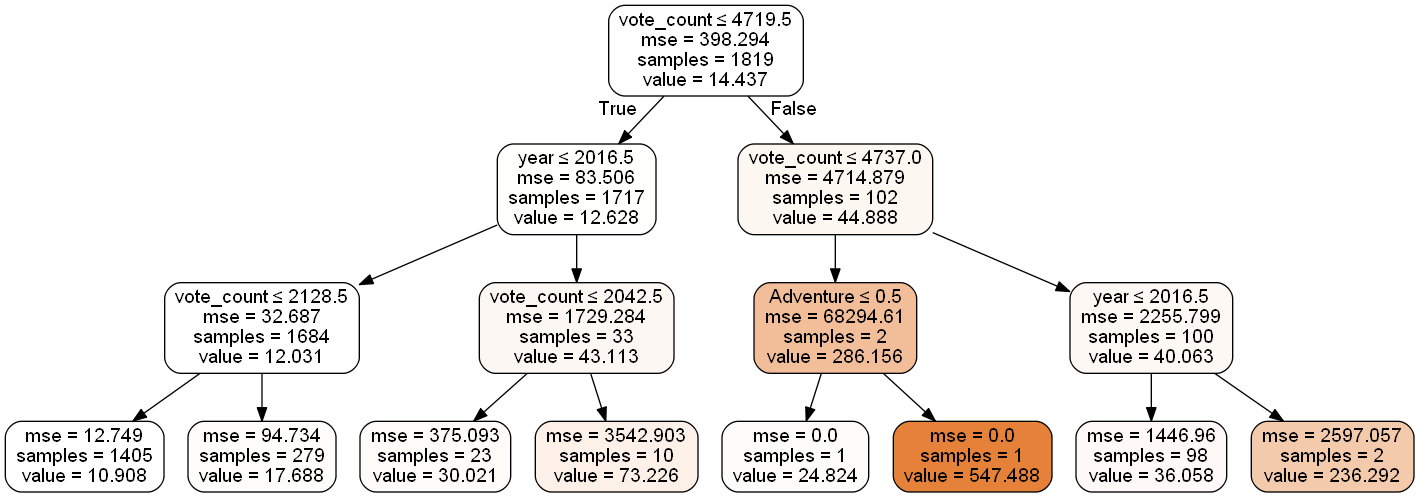

In [187]:
dot_data = StringIO()
export_graphviz(dtree, 
 out_file=dot_data,
 feature_names=X.columns, # the feature names.
 filled=True, # Whether to fill in the boxes with colours.
 rounded=True, # Whether to round the corners of the boxes.
 special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

MSE = MeanSquaredError /  Explain now the paradox from the previous question: whay are only 3 attributes used?

**Finish the experiments:
    1. Find the correct way to run the experiments and obtain experimental results over the test set
    2. Change the max depth and see what happens and report the results
    You should consider checking different options for your tree, as from https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [171]:
prediction = dtree.predict(X_test)
# The mean squared error
print("Mean absolute error: %.2f" %  mean_absolute_error(y_test, prediction))
print("Root Mean squared error: %.2f" %  sqrt(mean_squared_error(y_test, prediction)))
print("Median absolute error: %.2f" %  median_absolute_error(y_test, prediction))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, prediction))

Mean absolute error: 5.25
Root Mean squared error: 15.22
Median absolute error: 2.59
Variance score: 0.36


**Qu'apportent les mesures de mean et median absolute error? et la variance? Si je veux dire "dans x% des cas on fait moins de y erreurs"

In [193]:
res = pd.DataFrame(columns=["MAE", "MedAE", "RMSE", "R2"])
for i in range(1, len(X.columns)):
    dtree = DecisionTreeRegressor(max_depth=i)
    dtree.fit(X_train, y_train)
    prediction = dtree.predict(X_test)
    res.loc[len(res)] = [mean_absolute_error(y_test, prediction),median_absolute_error(y_test, prediction), 
                         sqrt(mean_squared_error(y_test, prediction)),r2_score(y_test, prediction)]

Text(0.5, 1.0, 'Variance')

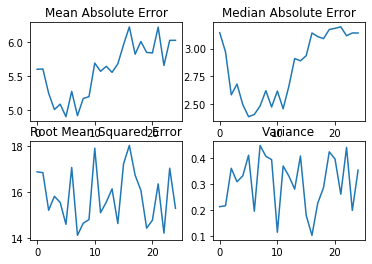

In [196]:
fig, ax = plt.subplots(2,2)
ax[0,0].plot(res["MAE"])
ax[0,0].set_title('Mean Absolute Error')
ax[0,1].plot(res["MedAE"])
ax[0,1].set_title('Median Absolute Error')
ax[1,0].plot(res["RMSE"])
ax[1,0].set_title('Root Mean Squared Error')
ax[1,1].plot(res["R2"])
ax[1,1].set_title('Variance')